In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn import metrics

import transformers
from transformers import BertTokenizer, BertModel, BertConfig
from transformers import Trainer,TrainingArguments
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import Trainer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader, RandomSampler, SequentialSampler

import matplotlib.pyplot as plt

import tensorflow as tf

In [2]:
from prog.DataCleaningEnglish import EnglishTextCleaning
from Models.EnglishTweets.Embeddings import Embeddings
from Models.EnglishTweets.CNN import CNN, ModelTrainer, load_data, evaluate_model, plot_losses
from Models.EnglishTweets.SVM import SVMModel, prepare_data_svm
from Models.EnglishTweets.LSTM import LSTMModel
from Models.EnglishTweets.HardVoting import HardVotingClassifier, prepare_data

In [3]:
"""pip install  tensorflow"""

'pip install  tensorflow'

In [4]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cpu


# Data preprocessing

In [5]:
train= pd.read_csv("/content/data/train.En.csv")
print(train.shape)

(3468, 10)


In [6]:
train.head()

,Unnamed: 0,tweet,sarcastic,rephrase,sarcasm,irony,satire,understatement,overstatement,rhetorical_question
0,0,The only thing I got from college is a caffein...,1,"College is really difficult, expensive, tiring...",0.0,1.0,0.0,0.0,0.0,0.0
1,1,I love it when professors draw a big question ...,1,I do not like when professors don’t write out ...,1.0,0.0,0.0,0.0,0.0,0.0
2,2,Remember the hundred emails from companies whe...,1,"I, at the bare minimum, wish companies actuall...",0.0,1.0,0.0,0.0,0.0,0.0
3,3,Today my pop-pop told me I was not “forced” to...,1,"Today my pop-pop told me I was not ""forced"" to...",1.0,0.0,0.0,0.0,0.0,0.0
4,4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1,I would say Ted Cruz is an asshole and doesn’t...,1.0,0.0,0.0,0.0,0.0,0.0


In [7]:
path2 = ('/content/data/train-balanced-sarcasm.csv')

external_data = pd.read_csv(path2)

In [8]:
external_data.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [9]:
external_data.shape

(1010826, 10)

In [10]:
external_data.drop(columns=["author","subreddit","score","ups","downs","date","created_utc","parent_comment"],inplace=True)

In [11]:
external_data.head()

,label,comment
0,0,NC and NH.
1,0,You do know west teams play against west teams...
2,0,"They were underdogs earlier today, but since G..."
3,0,"This meme isn't funny none of the ""new york ni..."
4,0,I could use one of those tools.


### traitement des valeurs manquantes

#### data initiale

In [12]:
train.isna().sum()

Unnamed: 0                0
tweet                     1
sarcastic                 0
rephrase               2601
sarcasm                2601
irony                  2601
satire                 2601
understatement         2601
overstatement          2601
rhetorical_question    2601
dtype: int64

In [13]:
simple_df = train[["tweet","sarcastic"]]
simple_df

,tweet,sarcastic
0,The only thing I got from college is a caffein...,1
1,I love it when professors draw a big question ...,1
2,Remember the hundred emails from companies whe...,1
3,Today my pop-pop told me I was not “forced” to...,1
4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1
...,...,...
3463,The population spike in Chicago in 9 months is...,0
3464,You'd think in the second to last English clas...,0
3465,I’m finally surfacing after a holiday to Scotl...,0
3466,Couldn't be prouder today. Well done to every ...,0


In [14]:
df = train.dropna()
df

,Unnamed: 0,tweet,sarcastic,rephrase,sarcasm,irony,satire,understatement,overstatement,rhetorical_question
0,0,The only thing I got from college is a caffein...,1,"College is really difficult, expensive, tiring...",0.0,1.0,0.0,0.0,0.0,0.0
1,1,I love it when professors draw a big question ...,1,I do not like when professors don’t write out ...,1.0,0.0,0.0,0.0,0.0,0.0
2,2,Remember the hundred emails from companies whe...,1,"I, at the bare minimum, wish companies actuall...",0.0,1.0,0.0,0.0,0.0,0.0
3,3,Today my pop-pop told me I was not “forced” to...,1,"Today my pop-pop told me I was not ""forced"" to...",1.0,0.0,0.0,0.0,0.0,0.0
4,4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1,I would say Ted Cruz is an asshole and doesn’t...,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
862,862,yo @claires do yall do hysterectomies?,1,"Claires, you should not do full hysterectomies.",1.0,0.0,0.0,0.0,0.0,1.0
863,863,@JacobWohlReport Do I need to aquire a wife be...,1,A lot of people don't have a wife.,1.0,0.0,0.0,0.0,0.0,1.0
864,864,I get a lot of boy who cried wolf vibes from t...,1,The red cross is always needy.,0.0,1.0,0.0,0.0,0.0,0.0
865,865,Update: holding hands with your mom and walkin...,1,Holding hands with your parent while walking a...,1.0,0.0,0.0,0.0,0.0,0.0


In [15]:
simple_df.isna().sum()

tweet        1
sarcastic    0
dtype: int64

In [16]:
simple_df = simple_df.dropna()
simple_df = simple_df.reset_index(drop = True)

In [17]:
simple_df['sarcastic'].value_counts()

sarcastic
0    2600
1     867
Name: count, dtype: int64

#### data externe

In [18]:
# Afficher les colonnes avec des valeurs NaN
columns_with_nan = external_data.columns[external_data.isna().any()].tolist()
print("Colonnes avec des valeurs NaN :", columns_with_nan)
# Nombre de valeurs NaN dans la colonne 'comment'
nan_count = external_data['comment'].isna().sum()
print("Nombre de valeurs NaN dans la colonne 'comment' :", nan_count)


Colonnes avec des valeurs NaN : ['comment']
Nombre de valeurs NaN dans la colonne 'comment' : 55


In [19]:
# Suppression des lignes avec des valeurs NaN dans la colonne 'comment'
external_data = external_data.dropna(subset=['comment'])

In [20]:
external_data.shape

(1010771, 2)

In [21]:
external_data["label"].value_counts(normalize=True)

label
0    0.500017
1    0.499983
Name: proportion, dtype: float64

### Réduction de la taille des données

In [22]:
# Sélectionner un échantillon aléatoire de 4 % des lignes
nb_lignes_a_conserver = int(0.04 * len(external_data))
external_data2 = external_data.sample(n=nb_lignes_a_conserver, random_state=42)  # On utilise random_state pour rendre la sélection reproductible

In [23]:
external_data2.shape

(40430, 2)

### Combiner les données externes et données initiales

In [24]:
simple_df.head()

,tweet,sarcastic
0,The only thing I got from college is a caffein...,1
1,I love it when professors draw a big question ...,1
2,Remember the hundred emails from companies whe...,1
3,Today my pop-pop told me I was not “forced” to...,1
4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1


In [25]:
# Réorganiser les colonnes
external_data2 = external_data2.reindex(columns=['comment', 'label'])
external_data2

,comment,label
355665,Yes and the buff it desperately needs,1
538060,Hilarious because i visited A2 one weekend las...,0
507644,Have you asked them what they want to eat?,0
519815,Because that worked out so well with the mater...,1
155398,But white people can't be discriminated against!,1
...,...,...
379942,I'm glad that Valve is finally focusing time a...,1
252515,They were probably holding off to see whether ...,0
821591,Don't feed the trolls unles you find their dou...,1
345929,cute &amp; gross,0


In [26]:
# Renommer les colonnes de la dataframe simple_df
simple_df = simple_df.rename(columns={'sarcastic': 'label', 'tweet': 'comment'})
simple_df

,comment,label
0,The only thing I got from college is a caffein...,1
1,I love it when professors draw a big question ...,1
2,Remember the hundred emails from companies whe...,1
3,Today my pop-pop told me I was not “forced” to...,1
4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1
...,...,...
3462,The population spike in Chicago in 9 months is...,0
3463,You'd think in the second to last English clas...,0
3464,I’m finally surfacing after a holiday to Scotl...,0
3465,Couldn't be prouder today. Well done to every ...,0


In [27]:
# Concaténer les deux dataframes
data = pd.concat([simple_df, external_data2], ignore_index=True)

data

,comment,label
0,The only thing I got from college is a caffein...,1
1,I love it when professors draw a big question ...,1
2,Remember the hundred emails from companies whe...,1
3,Today my pop-pop told me I was not “forced” to...,1
4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1
...,...,...
43892,I'm glad that Valve is finally focusing time a...,1
43893,They were probably holding off to see whether ...,0
43894,Don't feed the trolls unles you find their dou...,1
43895,cute &amp; gross,0


In [28]:
data.shape

(43897, 2)

### Enlever les liens

In [29]:
Pd = EnglishTextCleaning()

In [30]:
simple_df['comment'] = simple_df['comment'].apply(Pd.remove_links)
data['comment'] = data['comment'].apply(Pd.remove_links)

### Enlever les tags

In [31]:
import re
def remove_tags(text):

    return re.sub(r'@\w+', '', text)

simple_df['comment'] = simple_df['comment'].apply(remove_tags)
data['comment'] = data['comment'].apply(remove_tags)

### enlever les hashtags

In [32]:
simple_df = Pd.extract_hashtags(simple_df, 'comment', 'Hashtags')
data = Pd.extract_hashtags(data, 'comment', 'Hashtags')

simple_df['comment'] = simple_df['comment'].apply(Pd.remove_hashtags)
data['comment'] = data['comment'].apply(Pd.remove_hashtags)

In [33]:
simple_df['Hashtags'].value_counts()

Hashtags
[]                                3087
[#LoveIsland]                        2
[#WTF1]                              2
[#AEWAllOut]                         2
[#Eurovision]                        2
                                  ... 
[#AVFC, #AVLARS]                     1
[#beetwitter, #ecologytwitter]       1
[#AcademicTwitter]                   1
[#psychtoolbox]                      1
[#MontyPythonesqueDisses]            1
Name: count, Length: 365, dtype: int64

In [34]:
data['Hashtags'].value_counts()

Hashtags
[]                    43374
[#1]                     10
[#3232, #3232]            4
[#UnitedForGood]          2
[#PRS2021]                2
                      ...  
[#Snowden]                1
[#donate]                 1
[#raceforlife]            1
[#Notts]                  1
[#Triiiiiiiggered]        1
Name: count, Length: 491, dtype: int64

### enlever les caractères spéciaux

In [35]:
# Appliquer la fonction remove_special_chars() à la colonne 'Text'
simple_df['comment'] = simple_df['comment'].apply(Pd.remove_special_chars)
data['comment'] = data['comment'].apply(Pd.remove_special_chars)

### enlever les tabulations \t et new lines \n

In [36]:
simple_df['comment'] = simple_df['comment'].apply(Pd.remove_spaces_and_newlines)
data['comment'] = data['comment'].apply(Pd.remove_spaces_and_newlines)

### enlever les emojis

In [37]:

simple_df['Emojis'] = simple_df['comment'].apply(Pd.extract_emojis)
data['Emojis'] = data['comment'].apply(Pd.extract_emojis)


In [38]:
simple_df

,comment,label,Hashtags,Emojis
0,The only thing I got from college is a caffein...,1,[],[]
1,I love it when professors draw a big question ...,1,[],[]
2,Remember the hundred emails from companies whe...,1,[],[]
3,Today my poppop told me I was not forced to go...,1,[],[]
4,I did too and I also reported Cancun Cruz n...,1,[],[]
...,...,...,...,...
3462,The population spike in Chicago in 9 months is...,0,[],[]
3463,Youd think in the second to last English class...,0,[],[]
3464,Im finally surfacing after a holiday to Scotla...,0,[],[]
3465,Couldnt be prouder today Well done to every st...,0,"[#GCSEresults2021, #GCSEresults]",[]


In [39]:
data

,comment,label,Hashtags,Emojis
0,The only thing I got from college is a caffein...,1,[],[]
1,I love it when professors draw a big question ...,1,[],[]
2,Remember the hundred emails from companies whe...,1,[],[]
3,Today my poppop told me I was not forced to go...,1,[],[]
4,I did too and I also reported Cancun Cruz n...,1,[],[]
...,...,...,...,...
43892,Im glad that Valve is finally focusing time an...,1,[],[]
43893,They were probably holding off to see whether ...,0,[],[]
43894,Dont feed the trolls unles you find their douc...,1,[],[]
43895,cute amp gross,0,[],[]


# BERT

* Dans cette partie, on utilisera le modèle **Bert** pour avoir les embeddings des données initiales. Puis on va entrainer les modeles CNN, SVM et LSTM sur chaque dataset, et finalement appliquer un hard voting sur ces 3 modèles
* On va faire la meme chose pour les données combinnées (data initiale+ data externe).


## data initiale

In [40]:
simple_df

,comment,label,Hashtags,Emojis
0,The only thing I got from college is a caffein...,1,[],[]
1,I love it when professors draw a big question ...,1,[],[]
2,Remember the hundred emails from companies whe...,1,[],[]
3,Today my poppop told me I was not forced to go...,1,[],[]
4,I did too and I also reported Cancun Cruz n...,1,[],[]
...,...,...,...,...
3462,The population spike in Chicago in 9 months is...,0,[],[]
3463,Youd think in the second to last English class...,0,[],[]
3464,Im finally surfacing after a holiday to Scotla...,0,[],[]
3465,Couldnt be prouder today Well done to every st...,0,"[#GCSEresults2021, #GCSEresults]",[]


### Embeddings (Bert)

In [41]:
train,test=train_test_split(simple_df,test_size=0.2,random_state=42)
print(train.shape,test.shape)

(2773, 4) (694, 4)


In [42]:
train_tweets = train['comment'].values.tolist()
train_labels = train['label'].values.tolist()
test_tweets = test['comment'].values.tolist()
test_labels = test['label'].values.tolist()

train_tweets, val_tweets, train_labels, val_labels = train_test_split(train_tweets, train_labels,
                                                                            test_size=0.1,random_state=42,stratify=train_labels)

In [43]:
Ed = Embeddings()

In [44]:
tokenizer, train_encodings, val_encodings, test_encodings = Ed.bert(train_tweets, val_tweets, test_tweets)

In [45]:
trainset = Ed.create_dataset(train_encodings['input_ids'], train_labels)
valset = Ed.create_dataset(val_encodings['input_ids'], val_labels)
testset = Ed.create_dataset(test_encodings['input_ids'], test_labels)

In [46]:
print(trainset.shape)
trainset.head()

(2495, 2)


,tweet_embedding,label
0,"[101, 2821, 4658, 1045, 3298, 2000, 2082, 1999...",0
1,"[101, 2115, 2063, 2061, 2485, 2000, 4824, 2616...",1
2,"[101, 2040, 2292, 1996, 14533, 8632, 2039, 101...",1
3,"[101, 2296, 2051, 2619, 5176, 2033, 2055, 2893...",0
4,"[101, 2023, 13609, 2175, 2078, 2031, 2000, 392...",0


In [47]:
print(valset.shape)
valset.head()

(278, 2)


,tweet_embedding,label
0,"[101, 2166, 3125, 2003, 2000, 3113, 1996, 2827...",0
1,"[101, 6069, 2468, 1037, 3220, 2074, 2061, 1045...",0
2,"[101, 1045, 17704, 10587, 2191, 1037, 3836, 16...",0
3,"[101, 2028, 1997, 2026, 2147, 15416, 2288, 203...",0
4,"[101, 5223, 2252, 10047, 2343, 102, 0, 0, 0, 0...",0


In [48]:
print(testset.shape)
testset.head()

(694, 2)


,tweet_embedding,label
0,"[101, 2625, 2084, 1019, 2781, 2044, 2893, 2026...",0
1,"[101, 2293, 3773, 2321, 2095, 19457, 2108, 124...",1
2,"[101, 1045, 2131, 1037, 2843, 1997, 2879, 2040...",1
3,"[101, 10047, 2055, 2000, 2074, 3328, 2046, 103...",1
4,"[101, 2092, 2026, 12436, 14693, 23854, 19294, ...",0


### CNN

In [49]:
# Check dimensionality of feature vectors
Xtrain = np.array(trainset["tweet_embedding"].tolist(), dtype=np.float32)
Xval = np.array(valset["tweet_embedding"].tolist(), dtype=np.float32)
dim = max(len(Xtrain[0]), len(Xval[0]))
print("Number of features in X_train:", len(Xtrain[0]))
print("Number of features in X_val:", len(Xval[0]))
print("input size :", dim)

Number of features in X_train: 74
Number of features in X_val: 57
input size : 74


In [50]:
# Chargement des données
train_loader, val_loader, test_loader = load_data(trainset, valset, testset)

# Initialisation du modèle
input_size = dim
hidden_size = 64
output_size = 2  # Nombre de classes
model = CNN(dim, hidden_size, output_size)

# Entraînement du modèle
trainer = ModelTrainer(model, train_loader, val_loader)
train_losses, val_losses = trainer.train()

74 57
Epoch [20/100], Train Loss: 0.4940, Val Loss: 1.5503
Epoch [40/100], Train Loss: 0.3394, Val Loss: 1.4158
Epoch [60/100], Train Loss: 0.3193, Val Loss: 1.8232
Epoch [80/100], Train Loss: 0.2603, Val Loss: 2.2212
Epoch [100/100], Train Loss: 0.3389, Val Loss: 2.0835


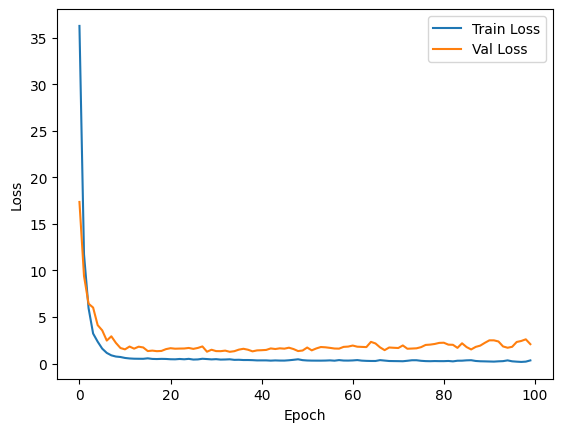

In [51]:
# Affichage de la courbe de perte
plot_losses(train_losses, val_losses)

In [52]:
# évaluation du modèle
precision, recall, f1 = evaluate_model(model, test_loader)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

Precision: 0.4964, Recall: 0.4976, F1-score: 0.4864


### SVM

In [53]:
X_train, y_train, X_val, y_val = prepare_data_svm(trainset, valset)
svm_model = SVMModel(kernel='linear', max_iter=100)
svm_model.train(X_train, y_train)
accuracy, f1 = svm_model.evaluate(X_val, y_val)
print("Accuracy on validation set:", accuracy)
print("F1-score on validation set:", f1)

Accuracy on validation set: 0.36330935251798563
F1-score on validation set: 0.3516483516483516


### LSTM

In [55]:
# Créer une instance de LSTMModel
lstm_model = LSTMModel(tokenizer)
lstm = lstm_model.train(trainset, testset)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 8)           244176    
                                                                 
 lstm (LSTM)                 (None, 8)                 544       
                                                                 
 dense (Dense)               (None, 4)                 36        
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 244761 (956.10 KB)
Trainable params: 244761 (956.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10


In [56]:
# Évaluer le modèle LSTM
lstm_model.evaluate_lstm(lstm, testset)

22/22 [==============================] - 1s 10ms/step
Accuracy: 0.28674351585014407
F1-score: 0.4456886898096304


### Hard voting

In [59]:
val_inputs_tensor, X_val, y_val, X_val_lstm = prepare_data(trainset, valset)

# Créer une instance de HardVotingClassifier
hard_voting_classifier = HardVotingClassifier(svm_model, lstm_model, lstm, model)

# Prédiction avec Hard Voting
voting_pred = hard_voting_classifier.predict(X_val, X_val_lstm, val_inputs_tensor)

# Calcul de l'accuracy
voting_accuracy = accuracy_score(y_val, voting_pred)
print("Accuracy with Hard Voting:", voting_accuracy)

# Calcul du f1-score
f1 = f1_score(y_val, voting_pred)
print("f1 score with Hard Voting:", f1)

9/9 [==============================] - 1s 8ms/step
Accuracy with Hard Voting: 0.34172661870503596
f1 score with Hard Voting: 0.35335689045936397


In [75]:
# Titre du tableau
titre = "F1-score des différents modèles pour data initale"

# Liste des scores F1
scores = [0.4864, 0.3516483516483516, 0.4456886898096304, 0.35335689045936397]
df_resultat1 = pd.DataFrame([scores], columns=['CNN', 'SVM', 'LSTM', 'Hard Voting'], index=['bert_data_initial'])

# Affichage du tableau avec titre
print(titre)
df_resultat1


F1-score des différents modèles pour data initale


,CNN,SVM,LSTM,Hard Voting
bert_data_initial,0.4864,0.351648,0.445689,0.353357


## data combinée

In [60]:
data

,comment,label,Hashtags,Emojis
0,The only thing I got from college is a caffein...,1,[],[]
1,I love it when professors draw a big question ...,1,[],[]
2,Remember the hundred emails from companies whe...,1,[],[]
3,Today my poppop told me I was not forced to go...,1,[],[]
4,I did too and I also reported Cancun Cruz n...,1,[],[]
...,...,...,...,...
43892,Im glad that Valve is finally focusing time an...,1,[],[]
43893,They were probably holding off to see whether ...,0,[],[]
43894,Dont feed the trolls unles you find their douc...,1,[],[]
43895,cute amp gross,0,[],[]


### Embeddings (Bert)

In [61]:
train,test=train_test_split(data,test_size=0.2,random_state=42)
print(train.shape,test.shape)

(35117, 4) (8780, 4)


In [63]:
train_tweets = train['comment'].values.tolist()
train_labels = train['label'].values.tolist()
test_tweets = test['comment'].values.tolist()
test_labels = test['label'].values.tolist()

train_tweets, val_tweets, train_labels, val_labels = train_test_split(train_tweets, train_labels,
                                                                            test_size=0.1,random_state=42,stratify=train_labels)

In [64]:
tokenizer, train_encodings, val_encodings, test_encodings = Ed.bert(train_tweets, val_tweets, test_tweets)

In [65]:
trainset = Ed.create_dataset(train_encodings['input_ids'], train_labels)
valset = Ed.create_dataset(val_encodings['input_ids'], val_labels)
testset = Ed.create_dataset(test_encodings['input_ids'], test_labels)

In [66]:
print(trainset.shape)
trainset.head()

(31605, 2)


,tweet_embedding,label
0,"[101, 2074, 2079, 2009, 2006, 2115, 8827, 2549...",1
1,"[101, 6842, 2622, 2154, 1017, 1999, 2049, 1570...",1
2,"[101, 17111, 2080, 2115, 2063, 4214, 1996, 740...",0
3,"[101, 2017, 2071, 2074, 2224, 2317, 2041, 2000...",0
4,"[101, 2008, 2015, 7782, 4105, 102, 0, 0, 0, 0,...",1


In [67]:
print(valset.shape)
valset.head()

(3512, 2)


,tweet_embedding,label
0,"[101, 2049, 7929, 2043, 2057, 2079, 2009, 102,...",1
1,"[101, 2129, 2515, 2002, 2377, 102, 0, 0, 0, 0,...",0
2,"[101, 2073, 2012, 102, 0, 0, 0, 0, 0, 0, 0, 0,...",0
3,"[101, 1040, 9333, 6051, 2894, 102, 0, 0, 0, 0,...",1
4,"[101, 6747, 2017, 2064, 3962, 1996, 5341, 3616...",1


In [68]:
print(testset.shape)
testset.head()

(8780, 2)


,tweet_embedding,label
0,"[101, 2030, 2028, 24759, 2271, 1016, 12692, 10...",1
1,"[101, 15488, 2003, 2428, 2204, 2007, 4363, 780...",1
2,"[101, 2017, 2064, 13387, 2008, 2125, 2007, 202...",0
3,"[101, 2987, 2102, 3043, 2998, 1998, 2769, 102,...",1
4,"[101, 2157, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1


In [ ]:
trainset.to_csv('/content/trainset_external_data.csv', index=False)
testset.to_csv('/content/testset_external_data.csv', index=False)
valset.to_csv('/content/valset_external_data.csv', index=False)


### CNN

In [69]:
# Check dimensionality of feature vectors
Xtrain = np.array(trainset["tweet_embedding"].tolist(), dtype=np.float32)
Xval = np.array(valset["tweet_embedding"].tolist(), dtype=np.float32)
dim = max(len(Xtrain[0]), len(Xval[0]))
print("Number of features in X_train:", len(Xtrain[0]))
print("Number of features in X_val:", len(Xval[0]))
print("input size :", dim)

Number of features in X_train: 512
Number of features in X_val: 104
input size : 512


In [70]:
# Chargement des données
train_loader, val_loader, test_loader = load_data(trainset, valset, testset)

# Initialisation du modèle
input_size = dim
hidden_size = 64
output_size = 2  # Nombre de classes
model = CNN(dim, hidden_size, output_size)

# Entraînement du modèle
trainer = ModelTrainer(model, train_loader, val_loader)
train_losses, val_losses = trainer.train()

512 104
Epoch [20/100], Train Loss: 0.6919, Val Loss: 0.6918
Epoch [40/100], Train Loss: 0.6919, Val Loss: 0.6916
Epoch [60/100], Train Loss: 0.6919, Val Loss: 0.6915
Epoch [80/100], Train Loss: 0.6919, Val Loss: 0.6916
Epoch [100/100], Train Loss: 0.6919, Val Loss: 0.6915


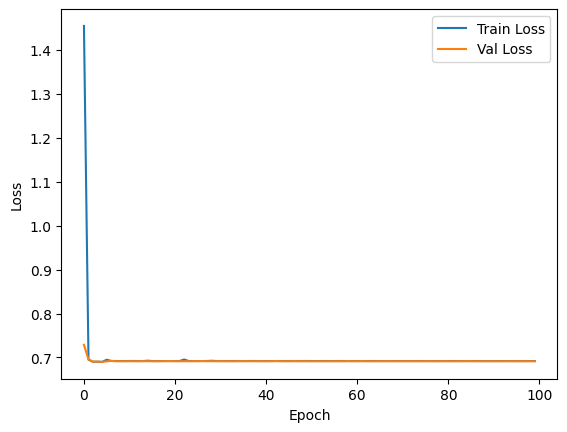

In [71]:
# Affichage de la courbe de perte
plot_losses(train_losses, val_losses)

In [76]:
# évaluation du modèle
precision, recall, f1 = evaluate_model(model, test_loader)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

Precision: 0.2575, Recall: 0.5000, F1-score: 0.3399


### SVM

In [72]:
X_train, y_train, X_val, y_val = prepare_data_svm(trainset, valset)
svm_model = SVMModel(kernel='linear', max_iter=100)
svm_model.train(X_train, y_train)
accuracy, f1 = svm_model.evaluate(X_val, y_val)
print("Accuracy on validation set:", accuracy)
print("F1-score on validation set:", f1)

Accuracy on validation set: 0.48832574031890663
F1-score on validation set: 0.5802382620882971


### LSTM

In [73]:
# Créer une instance de LSTMModel
lstm_model_dataf = LSTMModel(tokenizer)
lstm_dataf = lstm_model_dataf.train(trainset, testset)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 8)           244176    
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dense_2 (Dense)             (None, 4)                 36        
                                                                 
 dropout_1 (Dropout)         (None, 4)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 244761 (956.10 KB)
Trainable params: 244761 (956.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/1

In [74]:
# Évaluer le modèle LSTM
lstm_model_dataf.evaluate_lstm(lstm, testset)

275/275 [==============================] - 3s 10ms/step
Accuracy: 0.4849658314350797
F1-score: 0.6531676637521092


### hard voting

In [75]:
val_inputs_tensor, X_val, y_val, X_val_lstm = prepare_data(trainset, valset)

# Créer une instance de HardVotingClassifier
hard_voting_classifier_dataf = HardVotingClassifier(svm_model, lstm_model_dataf, lstm_dataf, model)

# Prédiction avec Hard Voting
voting_pred = hard_voting_classifier_dataf.predict(X_val, X_val_lstm, val_inputs_tensor)

# Calcul de l'accuracy
voting_accuracy = accuracy_score(y_val, voting_pred)
print("Accuracy with Hard Voting:", voting_accuracy)

# Calcul du f1-score
f1 = f1_score(y_val, voting_pred)
print("f1 score with Hard Voting:", f1)

110/110 [==============================] - 2s 10ms/step
Accuracy with Hard Voting: 0.48832574031890663
f1 score with Hard Voting: 0.5802382620882971


In [76]:
# Titre du tableau
titre = "F1-score des différents modèles pour data combinée"

# Liste des scores F1
scores = [0.3399, 0.5802382620882971, 0.6531676637521092, 0.5802382620882971]
df_resultat1 = pd.DataFrame([scores], columns=['CNN', 'SVM', 'LSTM', 'Hard Voting'], index=['bert_data_combinée'])

# Affichage du tableau avec titre
print(titre)
df_resultat1


F1-score des différents modèles pour data combinée


,CNN,SVM,LSTM,Hard Voting
bert_data_combinée,0.3399,0.580238,0.653168,0.580238


# RoBerta

* Dans cette partie, on utilisera le modèle **RoBerta** pour avoir les embeddings des données combinées (data initiale+ data externe). Puis on va entrainer les modeles CNN, SVM et LSTM sur chaque dataset, et finalement appliquer un hard voting sur ces 3 modèles


## Embeddings (RoBerta)

In [40]:
Ed = Embeddings()

In [41]:
train,test=train_test_split(data,test_size=0.2,random_state=42)
print(train.shape,test.shape)

(35117, 4) (8780, 4)


In [42]:
train_tweets = train['comment'].values.tolist()
train_labels = train['label'].values.tolist()
test_tweets = test['comment'].values.tolist()
test_labels = test['label'].values.tolist()

train_tweets, val_tweets, train_labels, val_labels = train_test_split(train_tweets, train_labels,
                                                                            test_size=0.1,random_state=42,stratify=train_labels)

In [43]:
tokenizer_roberta, train_encodings_roberta, val_encodings_roberta, test_encodings_roberta = Ed.roberta(train_tweets, val_tweets, test_tweets)

In [44]:
trainset_roberta = Ed.create_dataframe(train_encodings_roberta['input_ids'], train_labels)
valset_roberta = Ed.create_dataframe(val_encodings_roberta['input_ids'], val_labels)
testset_roberta = Ed.create_dataframe(test_encodings_roberta['input_ids'], test_labels)

In [45]:
print(trainset_roberta.shape)
trainset_roberta.head()

(31605, 2)


,tweet_embedding,label
0,"[0, 8987, 109, 24, 15, 110, 27778, 306, 50, 30...",1
1,"[0, 725, 1906, 1478, 3728, 1053, 155, 11, 63, ...",1
2,"[0, 104, 41242, 47, 241, 1765, 5, 15413, 435, ...",0
3,"[0, 6968, 115, 95, 304, 1104, 66, 7, 1719, 24,...",0
4,"[0, 11329, 2923, 7457, 1673, 2, 1, 1, 1, 1, 1,...",1


In [46]:
print(valset_roberta.shape)
valset_roberta.head()

(3512, 2)


,tweet_embedding,label
0,"[0, 30872, 15983, 77, 52, 109, 24, 2, 1, 1, 1,...",1
1,"[0, 6179, 473, 37, 310, 2, 1, 1, 1, 1, 1, 1, 1...",0
2,"[0, 13841, 23, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",0
3,"[0, 495, 13691, 8337, 1937, 2, 1, 1, 1, 1, 1, ...",1
4,"[0, 47566, 47, 64, 1514, 5, 5394, 1530, 350, 2...",1


In [47]:
print(testset_roberta.shape)
testset_roberta.head()

(8780, 2)


,tweet_embedding,label
0,"[0, 11094, 13988, 132, 11439, 2, 1, 1, 1, 1, 1...",1
1,"[0, 15153, 16, 269, 205, 19, 2396, 12200, 4143...",1
2,"[0, 1185, 64, 20011, 14, 160, 19, 65, 9, 167, ...",0
3,"[0, 27847, 3999, 948, 1612, 8, 418, 2, 1, 1, 1...",1
4,"[0, 4070, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1


## CNN

In [48]:
# Check dimensionality of feature vectors
Xtrain = np.array(trainset_roberta["tweet_embedding"].tolist(), dtype=np.float32)
Xval = np.array(valset_roberta["tweet_embedding"].tolist(), dtype=np.float32)
dim = max(len(Xtrain[0]), len(Xval[0]))
print("Number of features in X_train:", len(Xtrain[0]))
print("Number of features in X_val:", len(Xval[0]))
print("input size :", dim)

Number of features in X_train: 483
Number of features in X_val: 512
input size : 512


In [49]:
# Chargement des données
train_loader, val_loader, test_loader = load_data(trainset_roberta, valset_roberta, testset_roberta)

# Initialisation du modèle
input_size = dim
hidden_size = 64
output_size = 2  # Nombre de classes
model = CNN(dim, hidden_size, output_size)

# Entraînement du modèle
trainer = ModelTrainer(model, train_loader, val_loader)
train_losses, val_losses = trainer.train()

483 512
Epoch [20/100], Train Loss: 0.6905, Val Loss: 0.6918
Epoch [40/100], Train Loss: 0.6902, Val Loss: 0.9702
Epoch [60/100], Train Loss: 0.6901, Val Loss: 0.7554
Epoch [80/100], Train Loss: 0.6901, Val Loss: 0.7734
Epoch [100/100], Train Loss: 0.6900, Val Loss: 0.6919


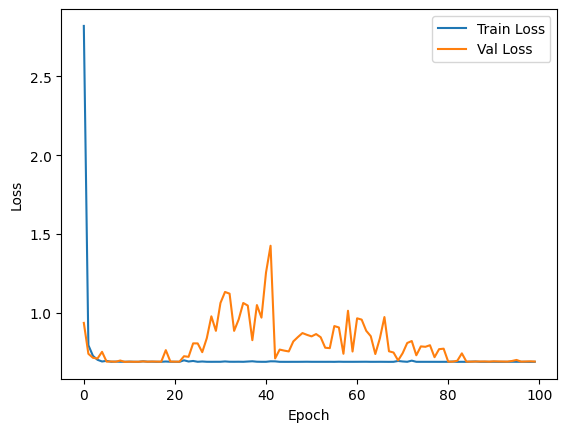

In [50]:
# Affichage de la courbe de perte
plot_losses(train_losses, val_losses)

In [51]:
# évaluation du modèle
precision, recall, f1 = evaluate_model(model, test_loader)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

Precision: 0.2575, Recall: 0.5000, F1-score: 0.3399


## SVM

In [52]:
X_train, y_train, X_val, y_val = prepare_data_svm(trainset_roberta, valset_roberta)
svm_model_roberta = SVMModel(kernel='linear', max_iter=100)
svm_model_roberta.train(X_train, y_train)
accuracy, f1 = svm_model_roberta.evaluate(X_val, y_val)
print("Accuracy on validation set:", accuracy)
print("F1-score on validation set:", f1)

Accuracy on validation set: 0.4854783599088838
F1-score on validation set: 0.6138063688822398


## LSTM

In [53]:
# Créer une instance de LSTMModel
lstm_model_roberta = LSTMModel(tokenizer_roberta)
lstm_roberta = lstm_model_roberta.train(trainset_roberta, testset_roberta)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 8)           402120    
                                                                 
 lstm (LSTM)                 (None, 8)                 544       
                                                                 
 dense (Dense)               (None, 4)                 36        
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 402705 (1.54 MB)
Trainable params: 402705 (1.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
988/

In [54]:
# Évaluer le modèle LSTM
lstm_model_roberta.evaluate_lstm(lstm_roberta, testset_roberta)

275/275 [==============================] - 4s 13ms/step
Accuracy: 0.4849658314350797
F1-score: 0.6531676637521092


## Hard voting

In [55]:
val_inputs_tensor, X_val, y_val, X_val_lstm = prepare_data(trainset_roberta, valset_roberta)

# Créer une instance de HardVotingClassifier
hard_voting_classifier_roberta = HardVotingClassifier(svm_model_roberta, lstm_model_roberta, lstm_roberta, model)

# Prédiction avec Hard Voting
voting_pred = hard_voting_classifier_roberta.predict(X_val, X_val_lstm, val_inputs_tensor)

# Calcul de l'accuracy
voting_accuracy_roberta = accuracy_score(y_val, voting_pred)
print("Accuracy with Hard Voting:", voting_accuracy_roberta)

# Calcul du f1-score
f1_roberta = f1_score(y_val, voting_pred)
print("f1 score with Hard Voting:", f1_roberta)

110/110 [==============================] - 4s 31ms/step
Accuracy with Hard Voting: 0.4854783599088838
f1 score with Hard Voting: 0.6138063688822398


In [77]:
# Titre du tableau
titre = "F1-score des différents modèles pour Roberta"

# Liste des scores F1
scores = [ 0.3399, 0.6138063688822398, 0.6531676637521092, 0.6138063688822398]
df_resultat1 = pd.DataFrame([scores], columns=['CNN', 'SVM', 'LSTM', 'Hard Voting'], index=['roberta'])

# Affichage du tableau avec titre
print(titre)
df_resultat1


F1-score des différents modèles pour Roberta


,CNN,SVM,LSTM,Hard Voting
roberta,0.3399,0.613806,0.653168,0.613806


# Deberta

* Dans cette partie, on utilisera le modèle **DeBerta** pour avoir les embeddings des données combinées (data initiale+ data externe). Puis on va entrainer les modeles CNN, SVM et LSTM sur chaque dataset, et finalement appliquer un hard voting sur ces 3 modèles


## Embeddings (Deberta)

In [56]:
Ed = Embeddings()

In [57]:
train,test=train_test_split(data,test_size=0.2,random_state=42)
print(train.shape,test.shape)

(35117, 4) (8780, 4)


In [58]:
train_tweets = train['comment'].values.tolist()
train_labels = train['label'].values.tolist()
test_tweets = test['comment'].values.tolist()
test_labels = test['label'].values.tolist()

train_tweets, val_tweets, train_labels, val_labels = train_test_split(train_tweets, train_labels,
                                                                            test_size=0.1,random_state=42,stratify=train_labels)

In [59]:
tokenizer_deberta, train_encodings_deberta, val_encodings_deberta, test_encodings_deberta = Ed.deberta(train_tweets, val_tweets, test_tweets)

In [60]:
trainset_deberta = Ed.create_dataframe(train_encodings_deberta['input_ids'], train_labels)
valset_deberta = Ed.create_dataframe(val_encodings_deberta['input_ids'], val_labels)
testset_deberta = Ed.create_dataframe(test_encodings_deberta['input_ids'], test_labels)

In [61]:
print(trainset_deberta.shape)
trainset_deberta.head()

(31605, 2)


,tweet_embedding,label
0,"[1, 348, 333, 278, 277, 290, 845, 268, 554, 28...",1
1,"[1, 9673, 2679, 1286, 404, 267, 359, 14822, 2,...",1
2,"[1, 95160, 274, 368, 2447, 262, 16007, 648, 26...",0
3,"[1, 274, 387, 348, 380, 881, 321, 264, 1134, 2...",0
4,"[1, 512, 268, 5819, 2297, 2, 0, 0, 0, 0, 0, 0,...",1


In [62]:
print(valset_deberta.shape)
valset_deberta.head()

(3512, 2)


,tweet_embedding,label
0,"[1, 2952, 5522, 335, 301, 333, 278, 2, 0, 0, 0...",1
1,"[1, 577, 490, 313, 612, 2, 0, 0, 0, 0, 0, 0, 0...",0
2,"[1, 2115, 288, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0
3,"[1, 23154, 430, 8736, 1585, 2, 0, 0, 0, 0, 0, ...",1
4,"[1, 10110, 274, 295, 1832, 262, 3571, 1687, 46...",1


In [63]:
print(testset_deberta.shape)
testset_deberta.head()

(8780, 2)


,tweet_embedding,label
0,"[1, 1434, 26881, 392, 11521, 2, 0, 0, 0, 0, 0,...",1
1,"[1, 13721, 269, 431, 397, 275, 1999, 7595, 194...",1
2,"[1, 367, 295, 11472, 272, 442, 275, 311, 265, ...",0
3,"[1, 15089, 297, 912, 1948, 263, 580, 2, 0, 0, ...",1
4,"[1, 423, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1


## CNN

In [64]:
# Check dimensionality of feature vectors
Xtrain = np.array(trainset_deberta["tweet_embedding"].tolist(), dtype=np.float32)
Xval = np.array(valset_deberta["tweet_embedding"].tolist(), dtype=np.float32)
dim = max(len(Xtrain[0]), len(Xval[0]))
print("Number of features in X_train:", len(Xtrain[0]))
print("Number of features in X_val:", len(Xval[0]))
print("input size :", dim)

Number of features in X_train: 482
Number of features in X_val: 512
input size : 512


In [65]:
# Chargement des données
train_loader, val_loader, test_loader = load_data(trainset_deberta, valset_deberta, testset_deberta)

# Initialisation du modèle
input_size = dim
hidden_size = 64
output_size = 2  # Nombre de classes
model_cnn_deberta = CNN(dim, hidden_size, output_size)

# Entraînement du modèle
trainer = ModelTrainer(model_cnn_deberta, train_loader, val_loader)
train_losses, val_losses = trainer.train()

482 512
Epoch [20/100], Train Loss: 0.6923, Val Loss: 0.6913
Epoch [40/100], Train Loss: 0.6919, Val Loss: 0.6915
Epoch [60/100], Train Loss: 0.6920, Val Loss: 0.6915
Epoch [80/100], Train Loss: 0.6930, Val Loss: 0.6915
Epoch [100/100], Train Loss: 0.6920, Val Loss: 0.6915


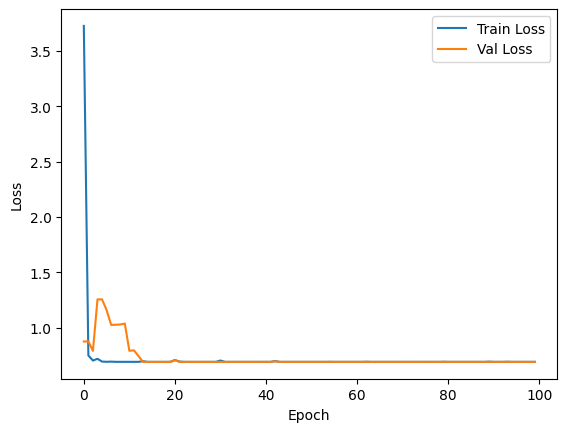

In [66]:
# Affichage de la courbe de perte
plot_losses(train_losses, val_losses)

In [67]:
# évaluation du modèle
precision, recall, f1 = evaluate_model(model_cnn_deberta, test_loader)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

Precision: 0.2575, Recall: 0.5000, F1-score: 0.3399


## SVM

In [68]:
X_train, y_train, X_val, y_val = prepare_data_svm(trainset_deberta, valset_deberta)
svm_model_deberta = SVMModel(kernel='linear', max_iter=100)
svm_model_deberta.train(X_train, y_train)
accuracy, f1 = svm_model_deberta.evaluate(X_val, y_val)
print("Accuracy on validation set:", accuracy)
print("F1-score on validation set:", f1)

Accuracy on validation set: 0.48234624145785876
F1-score on validation set: 0.63420523138833


## LSTM

In [69]:
# Créer une instance de LSTMModel
lstm_model_deberta = LSTMModel(tokenizer_deberta)
lstm_deberta = lstm_model_deberta.train(trainset_deberta, testset_deberta)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 8)           1024000   
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dense_2 (Dense)             (None, 4)                 36        
                                                                 
 dropout_1 (Dropout)         (None, 4)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 1024585 (3.91 MB)
Trainable params: 1024585 (3.91 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10


In [70]:
# Évaluer le modèle LSTM
lstm_model_deberta.evaluate_lstm(lstm_deberta, testset_deberta)

275/275 [==============================] - 3s 10ms/step
Accuracy: 0.4849658314350797
F1-score: 0.6531676637521092


## Hard Voting

In [72]:
val_inputs_tensor, X_val, y_val, X_val_lstm = prepare_data(trainset_deberta, valset_deberta)

# Créer une instance de HardVotingClassifier
hard_voting_classifier_deberta = HardVotingClassifier(svm_model_deberta, lstm_model_deberta, lstm_deberta, model_cnn_deberta)

# Prédiction avec Hard Voting
voting_pred = hard_voting_classifier_deberta.predict(X_val, X_val_lstm, val_inputs_tensor)

# Calcul de l'accuracy
voting_accuracy_deberta = accuracy_score(y_val, voting_pred)
print("Accuracy with Hard Voting:", voting_accuracy_deberta)

# Calcul du f1-score
f1_deberta = f1_score(y_val, voting_pred)
print("f1 score with Hard Voting:", f1_deberta)

110/110 [==============================] - 5s 44ms/step
Accuracy with Hard Voting: 0.48234624145785876
f1 score with Hard Voting: 0.63420523138833


In [78]:
# Titre du tableau
titre = "F1-score des différents modèles pour deberta"

# Liste des scores F1
scores = [ 0.3399, 0.63420523138833, 0.6531676637521092, 0.63420523138833]
df_resultat1 = pd.DataFrame([scores], columns=['CNN', 'SVM', 'LSTM', 'Hard Voting'], index=['deberta'])

# Affichage du tableau avec titre
print(titre)
df_resultat1


F1-score des différents modèles pour deberta


,CNN,SVM,LSTM,Hard Voting
deberta,0.3399,0.634205,0.653168,0.634205
